In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer


if False:  # Fetch from OpenML
    from sklearn.datasets import fetch_openml
    
    df = fetch_openml(data_id=45106, parser="pandas").frame
else:     # Fetch from repo
    df = pl.read_parquet("df.parquet")
df

year,town,driver_age,car_weight,car_power,car_age,claim_nb
f64,f64,f64,f64,f64,f64,i32
2018.0,1.0,51.0,1760.0,173.0,3.0,0
2019.0,1.0,41.0,1760.0,248.0,2.0,0
2018.0,1.0,25.0,1240.0,111.0,2.0,0
2019.0,0.0,40.0,1010.0,83.0,9.0,0
2018.0,0.0,43.0,2180.0,169.0,5.0,0
…,…,…,…,…,…,…
2019.0,1.0,45.0,1090.0,62.0,2.0,0
2019.0,1.0,45.0,1180.0,93.0,4.0,0
2018.0,1.0,31.0,1060.0,57.0,1.0,0


In [2]:
vars_discretize = ["driver_age", "car_weight", "car_power", "car_age"]
covs = vars_discretize
kbins_ordinal = KBinsDiscretizer(n_bins=5, encode="ordinal").set_output(transform="polars")
ordinal_data = kbins_ordinal.fit_transform(df[vars_discretize]).with_columns(
    df["claim_nb"],
    df["year"]
)
ordinal_data

driver_age,car_weight,car_power,car_age,claim_nb,year
f64,f64,f64,f64,i32,f64
3.0,4.0,4.0,2.0,0,2018.0
2.0,4.0,4.0,2.0,0,2019.0
0.0,2.0,2.0,2.0,0,2018.0
1.0,0.0,1.0,4.0,0,2019.0
2.0,4.0,4.0,3.0,0,2018.0
…,…,…,…,…,…
2.0,1.0,0.0,2.0,0,2019.0
2.0,2.0,1.0,3.0,0,2019.0
0.0,1.0,0.0,1.0,0,2018.0


In [3]:
ohe = OneHotEncoder(sparse_output=False).set_output(transform="polars")
X_train = ohe.fit_transform(ordinal_data.select(
    pl.all().exclude("claim_nb", "year")
))

In [4]:
from sklearn.linear_model import PoissonRegressor
glm = PoissonRegressor(alpha=1e-3)
glm.fit(X_train, df["claim_nb"])

PoissonRegressor(alpha=0.001)

In [5]:
years = np.arange(2010, 2020)
np.random.seed(500)
sample_years = np.random.choice(years, size=df.height)
df = df.with_columns(
    pl.lit(sample_years).alias("year"),
    pl.lit(glm.predict(X_train)).alias("y_hat")
)
ordinal_data = ordinal_data.with_columns(
    pl.lit(sample_years).alias("year"),
    pl.lit(glm.predict(X_train)).alias("y_hat")
).with_columns(
    pl.all().exclude("year", "claim_nb", "y_hat").cast(str),
)

In [6]:
factors_df = ordinal_data.select(
    pl.all().exclude("year", "claim_nb")
).unique()
factors_df

driver_age,car_weight,car_power,car_age,y_hat
str,str,str,str,f64
"""4.0""","""3.0""","""1.0""","""0.0""",0.083301
"""3.0""","""0.0""","""0.0""","""3.0""",0.060594
"""3.0""","""2.0""","""2.0""","""0.0""",0.079248
"""4.0""","""3.0""","""1.0""","""2.0""",0.078954
"""1.0""","""0.0""","""1.0""","""3.0""",0.07209
…,…,…,…,…
"""3.0""","""4.0""","""1.0""","""4.0""",0.064939
"""3.0""","""0.0""","""4.0""","""2.0""",0.102331
"""1.0""","""4.0""","""2.0""","""3.0""",0.082314


In [7]:
# factors_df.schema

In [8]:
def get_pivot_df(year1, year2, factors_df, data, covs):
    dist_1 = data.filter(
        pl.col("year") == year1
    )
    dist_2 = data.filter(
        pl.col("year") == year2
    )
    _ = dist_1.group_by(
        covs
    ).agg(
        pl.col("year").count().alias("n_obs")
    ).with_columns(
        (pl.col("n_obs") / pl.col("n_obs").sum()).alias("p_x")
    ).select(
        pl.lit(year1).alias("year"),
        pl.col(covs),
        pl.col("p_x")
    )
    distrs = _.clone()
    _ = dist_2.group_by(
        covs
    ).agg(
        pl.col("year").count().alias("n_obs")
    ).with_columns(
        (pl.col("n_obs") / pl.col("n_obs").sum()).alias("p_x")
    ).select(
        pl.lit(year2).alias("year"),
        pl.col(covs),
        pl.col("p_x")
    )
    distrs = pl.concat([distrs, _])
    pivot_df = distrs.pivot(
    index=covs,
    on="year"
    ).fill_null(0).with_columns(
        (pl.col(str(year2)) - pl.col(str(year1))).alias("delta_px")
    ).join(
        factors_df, on=covs
    ).with_columns(
        (pl.col("y_hat") * pl.col("delta_px")).alias("contribution")
    )
    return pivot_df, pivot_df["contribution"].sum()

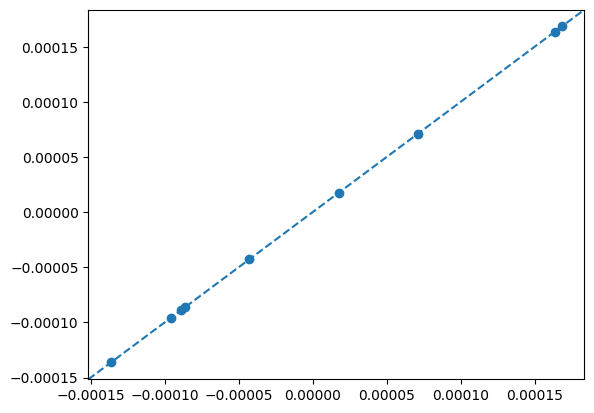

In [9]:
res = []
for year in df["year"].unique().sort()[:-1]:
    res.append(get_pivot_df(year, year + 1, factors_df, ordinal_data, covs))

obs_deltas = ordinal_data.group_by(
    "year"
).agg(
    pl.col("y_hat").mean()
).sort("year").select(
    pl.col("y_hat").diff().alias("diff")
).drop_nulls().to_numpy()
expected_deltas = [el[1] for el in res]
plt.axline((0, 0), slope=1., linestyle="--")
plt.scatter(expected_deltas, obs_deltas)

In [10]:
import plotly.express as px

In [11]:
res[0][0]

driver_age,car_weight,car_power,car_age,2010,2011,delta_px,y_hat,contribution
str,str,str,str,f64,f64,f64,f64,f64
"""4.0""","""3.0""","""1.0""","""0.0""",0.00036,0.000342,-0.000018,0.083301,-0.000002
"""3.0""","""0.0""","""0.0""","""3.0""",0.005342,0.005088,-0.000254,0.060594,-0.000015
"""3.0""","""2.0""","""2.0""","""0.0""",0.00098,0.000784,-0.000196,0.079248,-0.000016
"""4.0""","""3.0""","""1.0""","""2.0""",0.00163,0.001558,-0.000072,0.078954,-0.000006
"""1.0""","""0.0""","""1.0""","""3.0""",0.002611,0.002534,-0.000077,0.07209,-0.000006
…,…,…,…,…,…,…,…,…
"""3.0""","""4.0""","""1.0""","""4.0""",0.00036,0.000463,0.000102,0.064939,0.000007
"""3.0""","""0.0""","""4.0""","""2.0""",0.00015,0.000101,-0.000049,0.102331,-0.000005
"""1.0""","""4.0""","""2.0""","""3.0""",0.00098,0.000925,-0.000055,0.082314,-0.000005


In [12]:
fig = px.histogram(res[0][0], x="contribution", 
                #    range_x=(-1e-5, 1e-5)
                   )
# fig.update_layout(xaxis_tickformat = '.1s')
fig.update_layout(
    xaxis = dict(
        showexponent = 'all',
        exponentformat = 'e'
    )
)
fig.show()